In [1]:
import os
import shutil
import pathlib
import numpy as np
from google.colab import files
from sklearn import metrics
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools
import random
import locale
from tabulate import tabulate
import cv2

# Dataset

## Import data

In [2]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define basic directories
root_dir = '/content'
dataset_dir = '/content/drive/MyDrive/Chocolates detection'

In [4]:
# Create temp directories
temp_dirs = [f'{root_dir}/images', f'{root_dir}/labels']

for temp_dir in temp_dirs:
  if not os.path.exists(temp_dir):
    os.mkdir(temp_dir)

In [5]:
# Load images and labels to temp directories

for dir in [dataset_dir + '/images', dataset_dir + '/labels']:

  # Create a list for filenames of the directory
  filenames = os.listdir(dir)
  for filename in filenames:
    shutil.copy(f'{dir}/{filename}', f'{root_dir}/{dir[-6:]}/{filename}')

In [6]:
# Classes
class_names = ["Chocolate"]

## Data visualization

In [7]:
images_list = os.listdir(f'{root_dir}/images')
labels_list = os.listdir(f'{root_dir}/labels')

In [8]:
complete_images_list, complete_labels_list = [], []

for image in images_list:
  complete_images_list.append(f'{temp_dirs[0]}/{image}')
  complete_labels_list.append(f'{temp_dirs[1]}/{image.replace(".jpg",".txt")}')

In [9]:
"""
Visualize the distribution of instances of different classes among data in a table like:

----------------------------------------------------
|   Number of images     |   Number of instances   |
---------------------------------------------------|
|          250           |           1979          |
----------------------------------------------------

"""

number_of_images = len(images_list)
number_of_instances = 0

for image in complete_images_list:

  # Calculate number of instances for all images
  label = image.replace("images","labels").replace(".jpg",".txt")
  f = open(label, "r")
  for x in f:
    if x[0] == '0':
      number_of_instances += 1
  f.close()

In [10]:
# Define columns
data = [[number_of_images, number_of_instances]]

# Define column names
col_names = ["Number of images", "Number of instances"]

# Display table
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒════════════════════╤═══════════════════════╕
│   Number of images │   Number of instances │
╞════════════════════╪═══════════════════════╡
│                500 │                  3100 │
╘════════════════════╧═══════════════════════╛


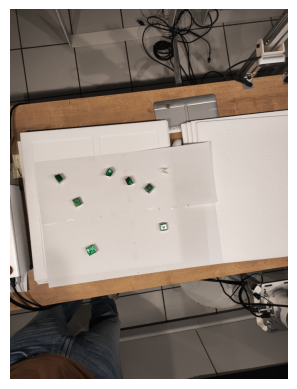

In [11]:
# Display N random images
N = 1
for _ in range(N):
  image_path = random.choice(complete_images_list)
  random_img = mpimg.imread(image_path)
  imgplot = plt.imshow(random_img)
  plt.axis("off")
  plt.show()

## Create train, valid and test subsets

In [12]:
subset_dirs = [f'{root_dir}/train', f'{root_dir}/valid', f'{root_dir}/test']

In [13]:
for subset in subset_dirs:
  if not os.path.exists(subset):
    os.mkdir(subset)
    os.mkdir(subset + "/images")
    os.mkdir(subset + "/labels")

In [14]:
# Sample 80% images and corresponding labels for the training set, 16% for the validation test and the rest 4% for the test set
train_images_list, train_labels_list, valid_images_list, valid_labels_list, test_images_list, test_labels_list = [], [], [], [], [], []

# Define train images
train_images_list.extend(random.sample(images_list, k = int(0.80*len(images_list))))
# Define valid images
remainders_list = [element for element in images_list if element not in train_images_list]
valid_images_list.extend(random.sample(remainders_list, k = int(0.80*len(remainders_list))))
# Define test images
test_images_list = [element for element in images_list if (element not in train_images_list and element not in valid_images_list)]

# Define train/valid/test labels
for i in range(len([train_labels_list, valid_labels_list, test_labels_list])):
  for j in range(len([train_images_list, valid_images_list, test_images_list][i])):
    [train_labels_list, valid_labels_list, test_labels_list][i].append([train_images_list, valid_images_list, test_images_list][i][j].replace(".jpg", ".txt"))

In [15]:
# Move images and labels to proper subdirectories and delete residual

for i in range(len([train_images_list, valid_images_list, test_images_list])):
  for element in [train_images_list, valid_images_list, test_images_list][i]:
    shutil.move(f'{temp_dirs[0]}/{element}', f'{subset_dirs[i]}/images/{element}')
shutil.rmtree(temp_dirs[0])

for i in range(len([train_labels_list, valid_labels_list, test_labels_list])):
  for element in [train_labels_list, valid_labels_list, test_labels_list][i]:
    shutil.move(f'{temp_dirs[1]}/{element}', f'{subset_dirs[i]}/labels/{element}')
shutil.rmtree(temp_dirs[1])

In [16]:
# Copy .yaml to "root" folder
shutil.copy(f'{dataset_dir}/path_to_data_&_configurations/config v7.yaml', root_dir)
shutil.copy(f'{dataset_dir}/path_to_data_&_configurations/path to data.yaml', root_dir)

'/content/path to data.yaml'

In [17]:
for dir in subset_dirs:
  for dirpath, dirnames, filenames in os.walk(dir):
    # List number of files
    print(f"There are {len(dirnames)} directories and {len(filenames)} filenames in '{dirpath}'.")

There are 2 directories and 0 filenames in '/content/train'.
There are 0 directories and 400 filenames in '/content/train/images'.
There are 0 directories and 400 filenames in '/content/train/labels'.
There are 2 directories and 0 filenames in '/content/valid'.
There are 0 directories and 80 filenames in '/content/valid/images'.
There are 0 directories and 80 filenames in '/content/valid/labels'.
There are 2 directories and 0 filenames in '/content/test'.
There are 0 directories and 20 filenames in '/content/test/images'.
There are 0 directories and 20 filenames in '/content/test/labels'.


# Model

In [18]:
# Install the ultralytics package
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.5/719.5 kB 10.1 MB/s eta 0:00:00


In [19]:
from ultralytics import YOLO

In [ ]:
"""
Load a YOLO model of size: nano (n), small (s), medium (m) , large (l) or x (huge)

model = YOLO('yolov8s.yaml')  # build a new model from YAML
model = YOLO('yolov8s.pt')  # load an official pretrained model (recommended for training)
model = YOLO('yolov8m.yaml').load('yolov8m.pt')  # build from YAML and transfer weights
model = YOLO("/content/drive/MyDrive/Models/best.pt") # load a custom pretrained model
"""

'\nLoad a YOLO model of size: nano (n), small (s), medium (m) , large (l) or x (huge)\n\nmodel = YOLO(\'yolov8s.yaml\')  # build a new model from YAML\nmodel = YOLO(\'yolov8s.pt\')  # load an official pretrained model (recommended for training)\nmodel = YOLO(\'yolov8m.yaml\').load(\'yolov8m.pt\')  # build from YAML and transfer weights\nmodel = YOLO("/content/drive/MyDrive/Models/best.pt") # load a custom pretrained model\n'

In [20]:
model = YOLO('yolov9c.yaml')

In [21]:
# Train the model
model.train(data = '/content/path to data.yaml', cfg = '/content/config v7.yaml', epochs=200, patience=50)

Ultralytics YOLOv8.1.24 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=None, data=/content/path to data.yaml, epochs=200, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

100%|██████████| 755k/755k [00:00<00:00, 26.5MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    212864  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 1]        
  3                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  4                  -1  1    847616  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 1]       
  5                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  6                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [512, 512, 512, 256, 1]       
  7                  -1  1    656384  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 115MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<00:00, 1415.68it/s]


train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/valid/labels... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<00:00, 1562.55it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      10.8G      3.829      13.02      4.474        114        640: 100%|██████████| 25/25 [00:36<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.99s/it]

                   all         80        507          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      11.2G      2.948      3.142      3.427        143        640: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         80        507          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      11.1G       2.65      2.259       2.86        147        640: 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         80        507          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      11.2G      2.451      1.916      2.287        123        640: 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]

                   all         80        507      0.186      0.122     0.0715     0.0267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      11.2G        2.2      1.803      2.006        142        640: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]

                   all         80        507      0.315      0.347      0.205     0.0531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200        11G      2.128      1.646      1.879        116        640: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         80        507      0.503      0.503      0.417      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      11.1G      1.891      1.393       1.69        126        640: 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all         80        507      0.613      0.604      0.525      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      11.1G      1.862      1.333      1.594        117        640: 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all         80        507      0.696      0.671      0.695      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      11.2G      1.851      1.294      1.536        120        640: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all         80        507      0.773      0.702      0.711      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      11.1G      1.814      1.278      1.479        167        640: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

                   all         80        507      0.761      0.801      0.773      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200        11G      1.718      1.191      1.471        123        640: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

                   all         80        507      0.842      0.647      0.695      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      11.1G      1.725      1.226      1.464        138        640: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]

                   all         80        507      0.255      0.306      0.127     0.0278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      11.2G      1.693      1.152      1.417        141        640: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]

                   all         80        507      0.595      0.568      0.506      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      11.1G      1.674      1.158      1.353        122        640: 100%|██████████| 25/25 [00:30<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         80        507      0.788      0.783      0.739      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200        11G      1.601       1.06      1.337        136        640: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all         80        507      0.794      0.744      0.693      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200        11G      1.615        1.1      1.331        130        640: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all         80        507      0.843      0.793      0.797      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      11.2G      1.601      1.071      1.335        120        640: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all         80        507       0.84      0.783      0.797      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200        11G        1.6      1.033       1.29        148        640: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         80        507      0.775      0.726      0.735      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200        11G      1.634      1.137      1.365        127        640: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all         80        507      0.798      0.788      0.842      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200        11G      1.604      1.089      1.317        127        640: 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         80        507      0.732      0.657      0.602      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      11.2G      1.539      1.012      1.298        149        640: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]

                   all         80        507      0.839      0.852      0.822       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      11.1G      1.539      1.001      1.295        116        640: 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all         80        507      0.696       0.72      0.615       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200        11G      1.551     0.9821      1.287        137        640: 100%|██████████| 25/25 [00:33<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all         80        507      0.805      0.753      0.711      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      11.1G      1.537     0.9882      1.323        128        640: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all         80        507      0.846      0.813      0.804      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      11.2G       1.53      0.941      1.232        120        640: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]

                   all         80        507      0.869      0.801      0.817      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200        11G      1.562      1.006      1.294        140        640: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all         80        507      0.736       0.68      0.667       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200        11G      1.531     0.9896      1.272        125        640: 100%|██████████| 25/25 [00:30<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all         80        507      0.731      0.722      0.647      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200        11G       1.48     0.9629      1.219        121        640: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

                   all         80        507      0.821       0.84      0.781      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      11.2G      1.481     0.9161      1.238        131        640: 100%|██████████| 25/25 [00:34<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

                   all         80        507      0.818      0.852      0.817      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200        11G      1.423     0.8907      1.208        104        640: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         80        507      0.887      0.856      0.865      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200        11G      1.479     0.9014      1.226        134        640: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         80        507       0.74      0.718      0.637      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200        11G      1.465     0.8826      1.225        107        640: 100%|██████████| 25/25 [00:34<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         80        507      0.777      0.765      0.668      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      11.2G      1.445     0.8837      1.234        158        640: 100%|██████████| 25/25 [00:33<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]

                   all         80        507      0.878      0.893      0.873      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200        11G      1.452     0.9234      1.238        144        640: 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         80        507      0.879      0.819      0.863      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      11.1G      1.415     0.8378      1.198        137        640: 100%|██████████| 25/25 [00:29<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

                   all         80        507      0.941      0.907      0.945      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      11.1G      1.494     0.8761      1.233        139        640: 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

                   all         80        507      0.892      0.786      0.876      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      11.2G       1.43     0.9013      1.196        158        640: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         80        507      0.831      0.858       0.84      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      11.3G      1.409     0.8585      1.205        141        640: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all         80        507      0.873      0.821      0.812      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200        11G      1.452     0.8298      1.203        147        640: 100%|██████████| 25/25 [00:29<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all         80        507      0.718      0.686      0.571      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200        11G      1.428     0.8403      1.193        120        640: 100%|██████████| 25/25 [00:29<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all         80        507      0.893      0.868      0.873       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      11.3G      1.364     0.8085      1.193        122        640: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

                   all         80        507      0.845      0.837      0.812      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      11.1G      1.421     0.8268      1.204        127        640: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]

                   all         80        507      0.846      0.826      0.798      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200        11G       1.33      0.775      1.153        130        640: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

                   all         80        507      0.915      0.908      0.915      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200        11G      1.371     0.8046      1.197        118        640: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all         80        507      0.937      0.938       0.95      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      11.2G      1.367     0.7973      1.172        119        640: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         80        507      0.889      0.866      0.867      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      11.1G      1.352      0.802      1.206        152        640: 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]

                   all         80        507      0.909      0.902      0.893      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      11.1G      1.368     0.8186      1.182        127        640: 100%|██████████| 25/25 [00:30<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all         80        507      0.919      0.884      0.906      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200        11G      1.395     0.8322      1.178        131        640: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all         80        507      0.918      0.905      0.913      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      11.3G      1.309     0.8015      1.198        136        640: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all         80        507       0.91      0.899      0.905      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      11.3G      1.329      0.782      1.182        133        640: 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all         80        507      0.835      0.836      0.809      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200        11G      1.397     0.8476      1.174        146        640: 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all         80        507      0.866       0.87      0.834        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      11.3G      1.344     0.8074       1.16        137        640: 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]

                   all         80        507      0.914      0.917      0.923      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      11.3G      1.318      0.777      1.171        135        640: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all         80        507      0.928      0.934       0.96      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      11.1G      1.311     0.7852      1.186        119        640: 100%|██████████| 25/25 [00:29<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]

                   all         80        507      0.916      0.913      0.925      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200        11G      1.349     0.7775      1.176        156        640: 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all         80        507       0.94      0.929      0.921      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200        11G      1.338     0.7554      1.154        162        640: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all         80        507      0.932      0.896      0.917      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      11.2G      1.301     0.7765      1.151        130        640: 100%|██████████| 25/25 [00:29<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]

                   all         80        507      0.912      0.927      0.903      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200        11G       1.33     0.7623      1.162        150        640: 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         80        507      0.931      0.938      0.939      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      11.1G      1.326     0.7392      1.157        119        640: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         80        507      0.945      0.935      0.957      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200        11G      1.233     0.6998      1.116        122        640: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         80        507      0.951      0.939      0.969      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      11.3G      1.271     0.6861      1.118        163        640: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

                   all         80        507      0.891      0.897      0.873      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      11.1G      1.378     0.7517      1.142        136        640: 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]

                   all         80        507      0.799      0.787      0.691      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      11.2G      1.362     0.7763      1.185        144        640: 100%|██████████| 25/25 [00:32<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all         80        507      0.903      0.885      0.875      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      11.1G      1.375       0.81       1.19        130        640: 100%|██████████| 25/25 [00:32<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         80        507      0.914      0.935      0.939      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      11.3G      1.277     0.7514      1.143        125        640: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all         80        507      0.924      0.909      0.903      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      11.1G      1.273      0.704      1.132        145        640: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]

                   all         80        507      0.931      0.928       0.95       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      11.1G      1.318     0.7065      1.113        135        640: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all         80        507      0.941      0.949      0.964      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      11.2G       1.32     0.7236      1.152        140        640: 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]

                   all         80        507       0.92      0.913        0.9      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      11.2G      1.288     0.6762      1.127        125        640: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

                   all         80        507      0.913      0.892      0.894      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      11.3G      1.318     0.7026      1.118        105        640: 100%|██████████| 25/25 [00:29<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all         80        507      0.907      0.913      0.892      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200        11G      1.265     0.6998      1.147        101        640: 100%|██████████| 25/25 [00:30<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all         80        507      0.949      0.949      0.953      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200        11G      1.287     0.6934      1.131        119        640: 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all         80        507      0.939       0.94      0.936      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      11.2G      1.264     0.6958      1.147        141        640: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         80        507      0.916      0.927      0.904      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200        11G      1.219     0.6959      1.124        150        640: 100%|██████████| 25/25 [00:29<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all         80        507      0.931      0.951      0.941      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200        11G      1.272      0.692      1.132        135        640: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

                   all         80        507      0.932      0.919      0.915      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      11.2G      1.234     0.6965      1.109        129        640: 100%|██████████| 25/25 [00:33<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all         80        507      0.931      0.934      0.933      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      11.2G      1.234     0.6777      1.131        127        640: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

                   all         80        507      0.933      0.945      0.946      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200        11G      1.224     0.6722      1.138        109        640: 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

                   all         80        507      0.927      0.949      0.937      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      11.2G      1.233     0.6531      1.122        139        640: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

                   all         80        507      0.958      0.944      0.962      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      11.1G      1.254     0.6763      1.128        132        640: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]

                   all         80        507      0.938      0.951      0.942      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      11.3G      1.244     0.6669      1.125        144        640: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all         80        507       0.95      0.943      0.956      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      11.1G      1.243     0.6608      1.144        140        640: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all         80        507      0.937      0.933      0.946      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      11.1G      1.273     0.6827      1.141        134        640: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

                   all         80        507      0.906      0.917      0.881      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200        11G      1.226     0.6751      1.124        105        640: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]

                   all         80        507      0.976      0.953      0.974      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      11.3G      1.247       0.67      1.148        132        640: 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all         80        507      0.933      0.908      0.931      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      11.1G      1.227     0.6621      1.102        127        640: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]

                   all         80        507      0.942      0.935      0.929      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200        11G       1.25     0.6593      1.119        136        640: 100%|██████████| 25/25 [00:33<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

                   all         80        507      0.958      0.931      0.968       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      11.3G      1.254     0.6651      1.169        146        640: 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all         80        507      0.954      0.946       0.96      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      11.2G      1.207     0.6514      1.104        137        640: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

                   all         80        507      0.946      0.943      0.939      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200        11G      1.256       0.66      1.113        142        640: 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]

                   all         80        507      0.959      0.922      0.949      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      11.3G      1.229     0.6735      1.114        123        640: 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]

                   all         80        507      0.962      0.954      0.971      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200        11G      1.236     0.6506      1.114        115        640: 100%|██████████| 25/25 [00:30<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all         80        507      0.965      0.965      0.977      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      11.2G       1.17     0.6416        1.1        161        640: 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all         80        507      0.929      0.899      0.937      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      11.1G      1.204     0.6318      1.114        160        640: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all         80        507      0.957      0.939      0.961      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      11.1G       1.17     0.6104        1.1        148        640: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         80        507      0.932      0.945      0.948       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      11.1G      1.265     0.6573      1.112        134        640: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

                   all         80        507      0.908      0.939      0.941       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      11.2G      1.184     0.6304      1.103        103        640: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all         80        507      0.958      0.959      0.952      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      11.1G      1.177     0.6325      1.102        121        640: 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

                   all         80        507      0.974      0.946      0.974      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200        11G      1.184     0.6273      1.107        163        640: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]

                   all         80        507      0.953      0.954      0.974      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      11.1G      1.218      0.662       1.13        128        640: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all         80        507       0.97      0.963      0.979      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      11.2G      1.198     0.6355      1.095        124        640: 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all         80        507      0.951      0.947      0.943      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200        11G      1.232     0.6468      1.096        118        640: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]

                   all         80        507       0.97      0.972      0.985      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      11.1G      1.182     0.6296      1.094        122        640: 100%|██████████| 25/25 [00:30<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

                   all         80        507      0.963      0.949       0.96       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200        11G      1.126     0.6064      1.086        118        640: 100%|██████████| 25/25 [00:29<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]

                   all         80        507       0.97      0.952      0.974      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      11.2G        1.2     0.6139        1.1        129        640: 100%|██████████| 25/25 [00:30<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

                   all         80        507      0.972      0.968      0.987      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200        11G      1.181     0.6318      1.111        125        640: 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all         80        507      0.964      0.958      0.962      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      11.1G      1.175     0.6024      1.096        161        640: 100%|██████████| 25/25 [00:33<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

                   all         80        507      0.972      0.962      0.978      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      11.1G      1.187      0.663      1.114        160        640: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

                   all         80        507      0.957      0.969      0.971      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      11.2G      1.179     0.6219      1.102        147        640: 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

                   all         80        507      0.944      0.961       0.95      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200        11G      1.135     0.5873      1.065        105        640: 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all         80        507      0.973      0.957       0.96      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      11.1G      1.151     0.6208        1.1        131        640: 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         80        507      0.967      0.963      0.977      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      11.1G      1.157     0.6074        1.1        105        640: 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

                   all         80        507      0.978      0.961      0.986        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      11.2G      1.156     0.5963      1.072        140        640: 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all         80        507      0.955      0.955      0.964      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      11.3G      1.149     0.5921      1.094        128        640: 100%|██████████| 25/25 [00:33<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

                   all         80        507      0.958      0.956      0.957       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200        11G      1.164      0.578       1.07        135        640: 100%|██████████| 25/25 [00:33<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]

                   all         80        507      0.977       0.97      0.985      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      11.1G      1.156     0.5856      1.101        145        640: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all         80        507      0.961      0.976       0.98      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      11.2G      1.133     0.5881      1.056        129        640: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

                   all         80        507      0.959      0.969      0.978      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      11.1G       1.12     0.5716      1.069        141        640: 100%|██████████| 25/25 [00:29<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all         80        507      0.957      0.978      0.973      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      11.1G      1.132     0.5702      1.045        106        640: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

                   all         80        507      0.961      0.984      0.984      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      11.2G      1.133     0.5855      1.083        149        640: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]

                   all         80        507      0.964      0.953      0.959      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      11.3G      1.136      0.571      1.067        142        640: 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]

                   all         80        507      0.968      0.964      0.957      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      11.3G      1.143     0.5652      1.066        113        640: 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all         80        507      0.959      0.968      0.965      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      11.1G      1.105     0.5537      1.049        124        640: 100%|██████████| 25/25 [00:32<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         80        507      0.964      0.948      0.969      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200        11G      1.153     0.5468      1.076        120        640: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all         80        507      0.971      0.964      0.981      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      11.2G      1.111     0.5471       1.06        132        640: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

                   all         80        507      0.977      0.978      0.989      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200        11G      1.128     0.5644      1.086        123        640: 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         80        507       0.98       0.98       0.99      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      11.1G      1.118     0.5627      1.073        102        640: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all         80        507       0.98      0.976      0.989      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200        11G      1.138     0.5611      1.056        117        640: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         80        507      0.977      0.963      0.979      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      11.2G      1.134     0.5679      1.069        127        640: 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all         80        507      0.968      0.972      0.976      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      11.3G      1.178     0.5828      1.081        137        640: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]

                   all         80        507      0.965      0.959      0.966      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      11.3G      1.108     0.5622      1.039        140        640: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

                   all         80        507      0.973      0.972      0.988      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200        11G      1.096     0.5563      1.035        118        640: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]

                   all         80        507      0.974      0.979      0.988      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      11.2G      1.116      0.548      1.075        122        640: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

                   all         80        507      0.974      0.974      0.987      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      11.2G      1.119     0.5614      1.068        161        640: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         80        507      0.962       0.98      0.978      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200        11G       1.09     0.5716      1.073        150        640: 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

                   all         80        507      0.972      0.964      0.969      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      11.5G      1.073     0.5408      1.068        114        640: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all         80        507      0.968      0.965      0.981      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      11.2G      1.093      0.557      1.055        169        640: 100%|██████████| 25/25 [00:32<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all         80        507      0.978      0.965      0.976      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200        11G      1.094     0.5479      1.067        175        640: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all         80        507      0.971      0.974      0.978      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      11.4G      1.106     0.5654      1.082        125        640: 100%|██████████| 25/25 [00:30<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         80        507      0.975      0.992      0.993       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      11.1G      1.099     0.5499      1.056        147        640: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all         80        507      0.993      0.978      0.994      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      11.2G      1.088     0.5423      1.058        144        640: 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all         80        507      0.983      0.968      0.982      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      11.4G      1.108     0.5449      1.071        163        640: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]

                   all         80        507      0.972      0.973      0.982      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      11.4G      1.155     0.5683      1.118        124        640: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]

                   all         80        507      0.951      0.953      0.954       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      11.4G      1.104     0.5496      1.077        148        640: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all         80        507      0.966      0.964      0.974      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      11.2G        1.1     0.5378      1.047        116        640: 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all         80        507      0.982      0.966      0.979       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      11.1G      1.103     0.5421      1.051        120        640: 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         80        507      0.965      0.979       0.98      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200        11G      1.073     0.5369      1.053        110        640: 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         80        507       0.98      0.973      0.979      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      11.1G      1.117     0.5431      1.045        127        640: 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all         80        507      0.974      0.964      0.979      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      11.2G      1.046     0.5332      1.039        142        640: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]

                   all         80        507      0.971      0.978      0.989      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      11.1G      1.089     0.5309      1.039        150        640: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]

                   all         80        507      0.973      0.979      0.984      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      11.1G      1.046     0.5171      1.046        118        640: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

                   all         80        507      0.974       0.97      0.979      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      11.1G       1.13     0.5444      1.062        126        640: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]

                   all         80        507      0.986      0.972      0.991       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      11.2G      1.082     0.5352      1.063        158        640: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all         80        507      0.983      0.966      0.983      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      11.2G      1.082     0.5295      1.053        163        640: 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         80        507      0.978      0.971      0.979      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200        11G      1.089     0.5414      1.059        142        640: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all         80        507      0.982       0.98      0.992      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200        11G      1.032     0.5142       1.03        137        640: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all         80        507      0.981      0.978      0.991      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      11.2G       1.08     0.5205      1.027        151        640: 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all         80        507      0.976      0.982      0.989      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200        11G      1.077      0.519       1.05        141        640: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all         80        507      0.987      0.976      0.994      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200        11G      1.043     0.4986      1.019        119        640: 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]

                   all         80        507       0.99      0.977      0.994      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200        11G      1.068     0.5029      1.038        169        640: 100%|██████████| 25/25 [00:33<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]

                   all         80        507      0.988      0.979      0.993      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      11.2G      1.075     0.5159      1.034        139        640: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]

                   all         80        507      0.973      0.986      0.991      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200        11G      1.107     0.5315      1.058        104        640: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]

                   all         80        507      0.987       0.98      0.994      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      11.1G      1.038     0.5112      1.044        148        640: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]

                   all         80        507      0.986      0.984      0.994      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200        11G      1.082     0.5147       1.05        129        640: 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         80        507      0.982      0.986      0.993      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      11.2G      1.051     0.5062      1.026        135        640: 100%|██████████| 25/25 [00:33<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         80        507      0.982      0.988      0.993      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      11.2G       1.01     0.4924       1.02        152        640: 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

                   all         80        507      0.979      0.982      0.992      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      11.1G       1.03     0.5072      1.047        109        640: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         80        507      0.986      0.982      0.992      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200        11G      1.074     0.5247      1.037        109        640: 100%|██████████| 25/25 [00:33<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         80        507      0.987      0.984      0.994      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      11.2G      1.036     0.4944      1.005        142        640: 100%|██████████| 25/25 [00:34<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all         80        507       0.98      0.983      0.991      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200        11G       1.04     0.5014      1.037        137        640: 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]

                   all         80        507       0.98      0.977      0.981      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      11.3G      1.032     0.4994      1.032        154        640: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all         80        507      0.981       0.97      0.978      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200        11G      1.012     0.4862       1.02        158        640: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]

                   all         80        507      0.976      0.981      0.981       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      11.2G       1.01     0.4813      1.029        129        640: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         80        507      0.973      0.978      0.983      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      11.1G      1.038     0.5004      1.027        166        640: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all         80        507      0.986      0.984      0.994      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200        11G       1.01      0.488      1.022        130        640: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]

                   all         80        507      0.988      0.994      0.994      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      11.1G       1.05     0.4952      1.035        124        640: 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]

                   all         80        507      0.982       0.99      0.993      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      11.2G      1.028     0.4936      1.041        128        640: 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]

                   all         80        507      0.984      0.987      0.993       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200        11G      1.041     0.4985      1.047        125        640: 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]

                   all         80        507       0.98      0.983      0.984      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      11.1G      1.055     0.4977      1.032        126        640: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all         80        507      0.984      0.987      0.994      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200        11G      1.041      0.502      1.047        133        640: 100%|██████████| 25/25 [00:33<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         80        507      0.976      0.979      0.991      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      11.2G      1.038     0.4939      1.034        149        640: 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

                   all         80        507      0.984      0.987      0.994      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200        11G      1.056     0.4941      1.036        148        640: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

                   all         80        507      0.988      0.986      0.994      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      11.1G     0.9996     0.4761      1.023        109        640: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all         80        507      0.987      0.982      0.994      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200        11G      1.008     0.4876      1.027        127        640: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]

                   all         80        507      0.988      0.988      0.994      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      11.3G       1.01     0.4831      1.032        120        640: 100%|██████████| 25/25 [00:33<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all         80        507      0.986       0.99      0.994      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      11.3G      1.033     0.4889      1.025        124        640: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

                   all         80        507      0.986      0.995      0.994      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      11.1G      1.015     0.4873      1.042        137        640: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all         80        507      0.992      0.994      0.994      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      11.1G     0.9915     0.4691      1.017        106        640: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]

                   all         80        507       0.99      0.985      0.994      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      11.3G      1.005     0.4743     0.9975        137        640: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

                   all         80        507      0.988      0.987      0.994      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200        11G      1.013     0.4735      1.031        151        640: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         80        507      0.984      0.988      0.994      0.698


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200        11G     0.9657     0.4474     0.9767         89        640: 100%|██████████| 25/25 [00:41<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

                   all         80        507      0.988      0.984      0.995       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200        11G     0.9955     0.4518     0.9853        114        640: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]

                   all         80        507       0.99      0.986      0.994       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      11.3G     0.9722     0.4425     0.9819         98        640: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all         80        507       0.99      0.987      0.994      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      11.1G     0.9705     0.4378      0.984        105        640: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

                   all         80        507      0.987      0.988      0.994      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      11.1G     0.9637     0.4432     0.9795        132        640: 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

                   all         80        507       0.99       0.98      0.994      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      11.1G     0.9665     0.4364     0.9894         94        640: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all         80        507       0.99      0.988      0.994      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      11.3G     0.9559     0.4359     0.9667         98        640: 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all         80        507       0.99      0.992      0.995      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      11.1G     0.9711     0.4345     0.9724         81        640: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

                   all         80        507      0.994      0.981      0.994      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      11.1G     0.9593     0.4287     0.9701         93        640: 100%|██████████| 25/25 [00:29<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all         80        507      0.996      0.985      0.995      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      11.1G     0.9547      0.433     0.9684         85        640: 100%|██████████| 25/25 [00:29<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

                   all         80        507      0.995      0.984      0.994      0.693



200 epochs completed in 2.265 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 51.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 51.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.24 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9c summary (fused): 384 layers, 25320019 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


                   all         80        507      0.988      0.988      0.994      0.704
Speed: 0.3ms preprocess, 14.7ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x786cb5a92860>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Save the model

In [22]:
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
# Save the trained model to local drive
"""
!zip -r '(08-11-23) YOLOv8m (200 ep)'.zip /content/runs
files.download('(08-11-23) YOLOv8m (200 ep).zip')
"""

In [23]:
# Save the trained model to Google Drive
!scp -r /content/runs '/content/drive/MyDrive/Chocolates detection/models/20240306_YOLOv9_v_6_7_200_1'

In [ ]:
# Save the trained model to Google Drive
!scp -r /content/runs '/content/drive/MyDrive/TWI Hellas/Chocolates detection/models/20240202_v_6_7_700_2'

# Object detection

In [ ]:
complete_test_images = []
temp_test_images = random.choices(test_images_list)
for test_image in test_images_list:
  complete_test_images.append(f'{subset_dirs[2]}/images/{test_image}')

In [ ]:
# Perform object detection to the images
results = model.predict(complete_test_images, conf=0.6, iou = 0.3)


0: 640x640 6 Chocolates, 1: 640x640 6 Chocolates, 2: 640x640 1 Chocolate, 3: 640x640 7 Chocolates, 4: 640x640 7 Chocolates, 5: 640x640 7 Chocolates, 6: 640x640 2 Chocolates, 7: 640x640 7 Chocolates, 8: 640x640 9 Chocolates, 9: 640x640 22 Chocolates, 293.6ms
Speed: 6.2ms preprocess, 29.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


## #1 way to plot results (auto)

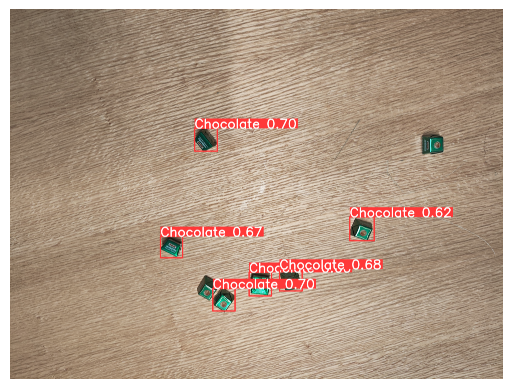


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



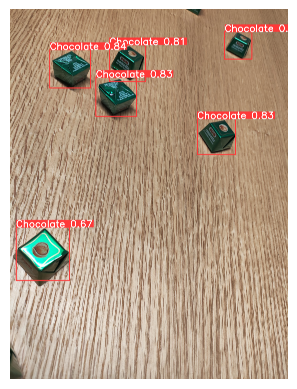


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



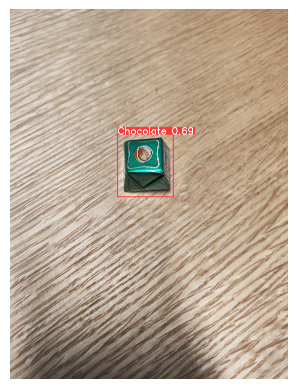


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



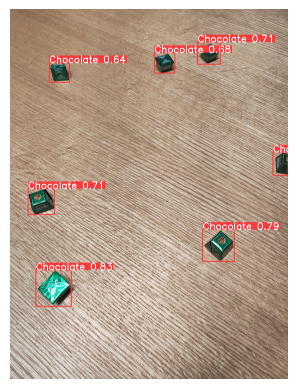


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



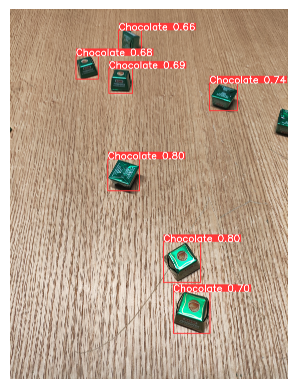


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



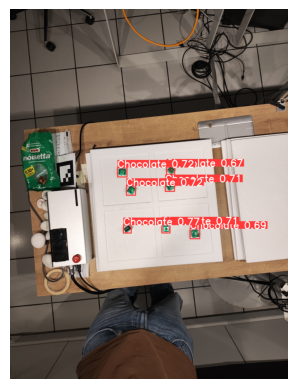


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



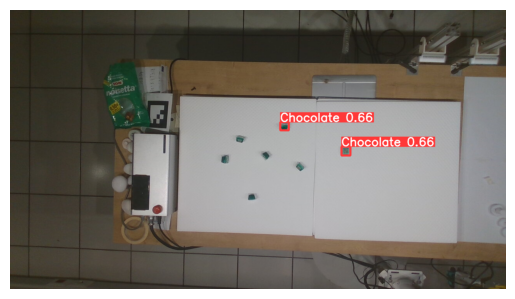


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



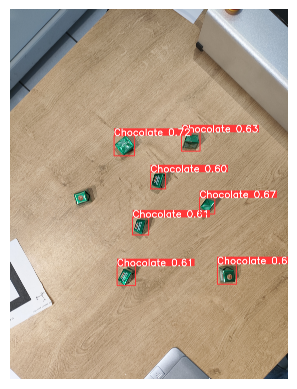


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



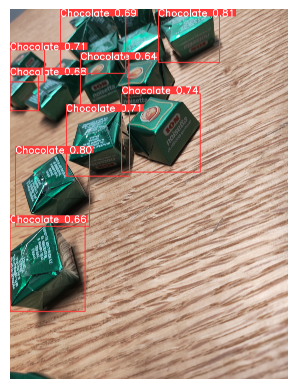


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



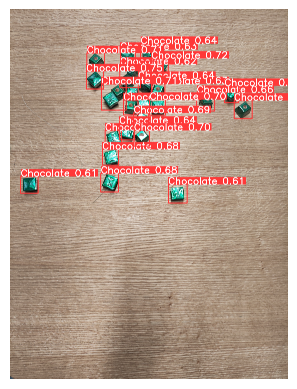


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



In [ ]:
# Plot results
for pointer in range(len(results)):

  """
  # Print the objects detected in the image
  for box in results[pointer].boxes:
    conf = round(box.conf[0].item(), 2)
    if conf > 0.8:
      class_id = results[pointer].names[box.cls[0].item()]
      cords = box.xyxy[0].tolist()
      cords = [round(x) for x in cords]
      print("Probability:", conf)
      print("Object type:", class_id)
      print("Coordinates:", cords)
      print("-------------------------------------------------\n")
  """

  # Show the image with the object detections
  result_nparray = results[pointer].plot()
  result_nparray = cv2.cvtColor(result_nparray, cv2.COLOR_BGR2RGB)
  plt.imshow(result_nparray)
  plt.axis("off")
  plt.show()
  print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")

## #2 way to plot results (manual)

In [ ]:
def box_label(image_file, box, label='', color=(), txt_color=(255, 255, 255)):

  # Add title, remove axes
  ax.axis("off")

  # Draw bounding box
  lw = max(round(sum(image.shape) / 2 * 0.0003), 2)
  p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
  rect1 = patches.Rectangle(p1, p2[0]-p1[0], p2[1]-p1[1], linewidth=lw, edgecolor = color, facecolor = 'None')
  ax.add_patch(rect1)

  if label:
    fs = lw*4
    ax.text(p1[0], p1[1], label, fontsize = fs,  color = 'w', bbox= dict(facecolor=color))

In [ ]:
def plot_bboxes(image, boxes, labels=[], colors=[], score=True, conf=None):
  #Define Labels
  if labels == []:
    labels = {0: u'Chocolate'}

  #Define colors
  if colors == []:
    colors = ['r']

  #plot each boxes
  for box in boxes:
    #add score in label if score=True
    if score :
      label = labels[int(box[-1])] + " " + str(round(100 * float(box[-2]),1)) + "%"
    else :
      label = labels[int(box[-1])]
    #filter every box under conf threshold if conf threshold setted
    if conf :
      if box[-2] > conf:
        color = colors[int(box[-1])]
        box_label(image, box, label, color)
    else:
      color = colors[int(box[-1])]
      box_label(image, box, label, color)

  plt.show()

In [ ]:
for index in range(len(test_images_list)):
  image_file = test_images_list[index]
  image_file = f'{subset_dirs[2]}/images/{image_file}'
  # Read and plot main image
  image = mpimg.imread(image_file)
  fig, ax = plt.subplots()
  ax.imshow(image)

  plot_bboxes(image_file, results[index].boxes.data, score=True)
  print("\n++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")

# Confusion matrix

In [ ]:
complete_valid_images = []
for valid_image in valid_images_list:
  complete_valid_images.append(f'{subset_dirs[1]}/images/{valid_image}')

In [ ]:
valid_results = model.predict(complete_valid_images)

In [ ]:
pred_labels, true_labels = [], []

for valid_result in valid_results:

  true_labels_file = valid_result.path.replace("images","labels").replace(".jpg",".txt")
  f = open(true_labels_file, "r")
  for x in f:
    val1 = float(x[2:10])
    for i in range(len(valid_result.boxes.xywhn)):
      val2 = valid_result.boxes.xywhn[i][0]
      if abs(val1-val2) < 0.01:
        pred_labels.append(str(int(valid_result.boxes.cls[i])))
        true_labels.append(x[0])

In [ ]:
cm = []
n = len(class_names)
for i in range(n):
  cm.append([])
  for j in range(n):
    cm[i].append(0)

for ind in range(len(pred_labels)):
  cm[int(true_labels[ind])][int(pred_labels[ind])] += 1
cm = np.array(cm)

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Plots a confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [ ]:
plot_confusion_matrix(cm, class_names)